<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7735/799985837.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


(35.0, 50.0)

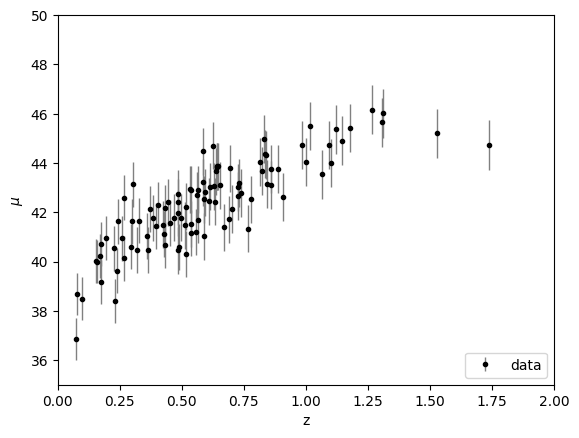

In [1]:
import numpy as np
import pylab as plt
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

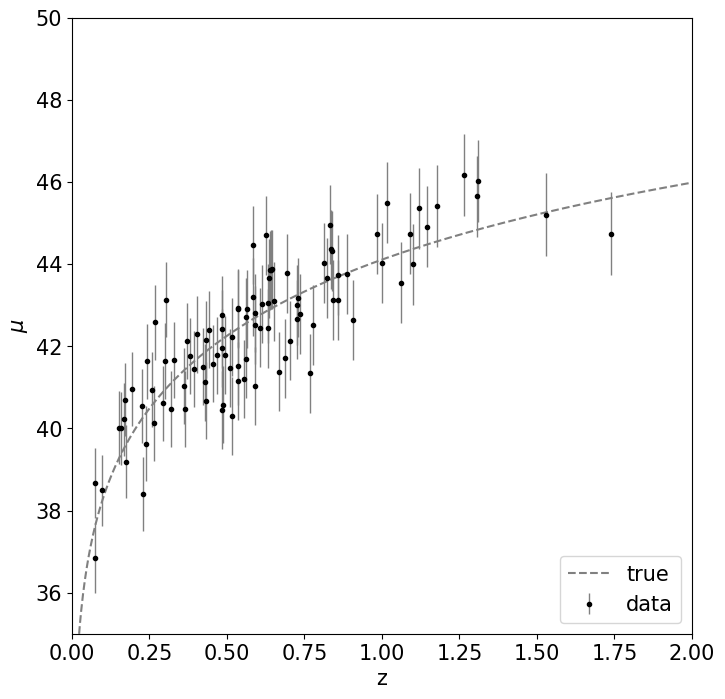

In [19]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, '--', c='gray',label='true')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

# Part 1. Different regression algorithms

### Linear regression


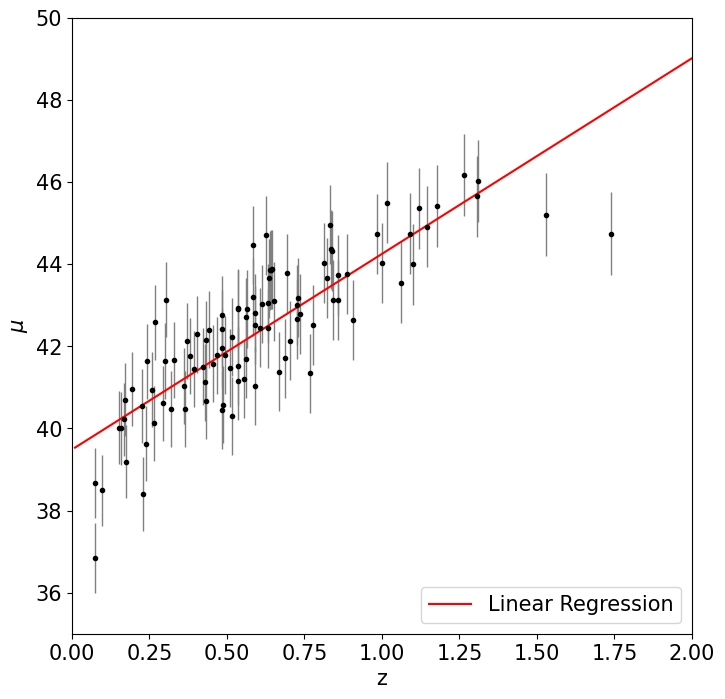

In [20]:
regressor = astroML.linear_model.LinearRegression()
regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
mu_fit = regressor.predict(z[:,np.newaxis])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.plot(z, mu_fit, '-r',label='Linear Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

### Polynomial regression

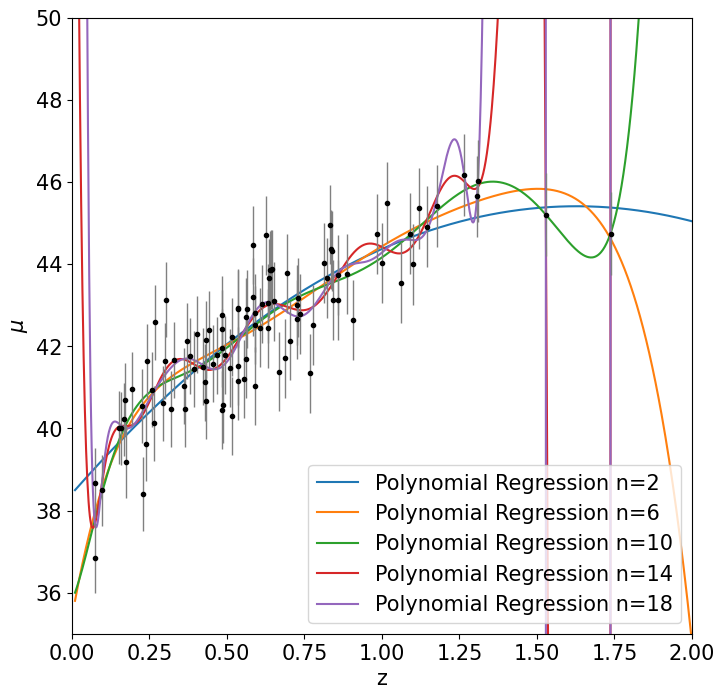

In [21]:
for n in np.arange(1,20)[1::4]:

    regressor = astroML.linear_model.PolynomialRegression(n)
    regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Polynomial Regression n='+str(n))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

### Basis Function Regression

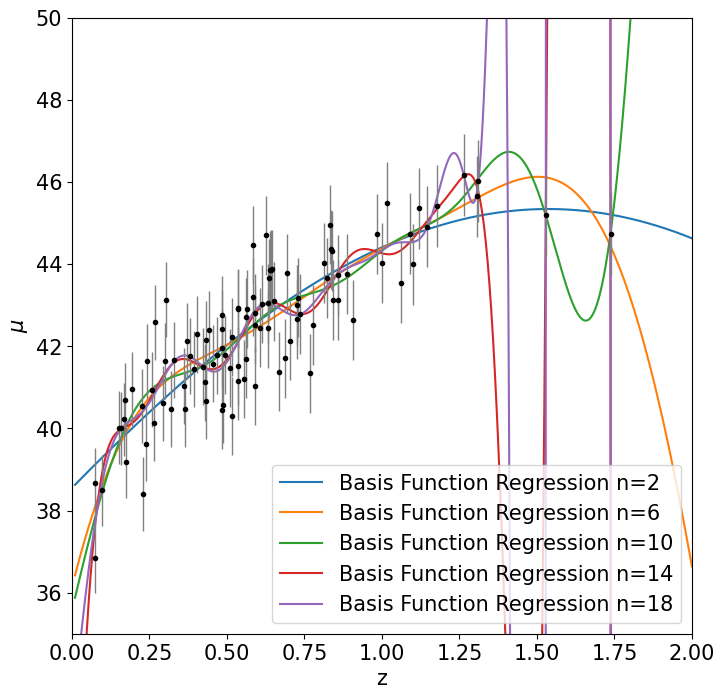

In [23]:
for n in np.arange(1,20)[1::4]:

    basis_mu = np.linspace(0,2,n)[:, None]
    basis_sigma = 1.0 * (basis_mu[1] - basis_mu[0])

    regressor = astroML.linear_model.BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit = regressor.predict(z[:,np.newaxis])
   
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Basis Function Regression n='+str(n))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

### Kernel regression (Nadaraya-Watson)

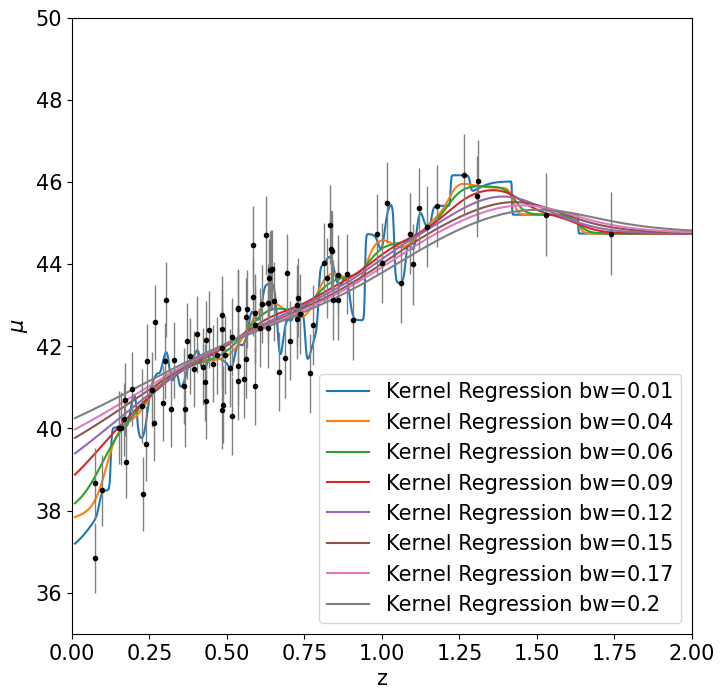

In [11]:
for bw in np.round(np.linspace(0.01,0.2,8),2):

    regressor = astroML.linear_model.NadarayaWatson('gaussian', bw)

    regressor.fit(z_sample[:,np.newaxis], mu_sample) # in this case dy is irrelevant!
    mu_fit = regressor.predict(z[:,np.newaxis])
   
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Kernel Regression bw='+str(bw))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## Part 2. Cross validation

Let's estimate the fit with cross-validation.


The following, very unfortuntately, does not work!


In [24]:
bwrange = np.linspace(0.01,0.2,8)
K=10

grid = GridSearchCV(astroML.linear_model.NadarayaWatson(), {'kernel':['gaussian'],'h': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(z_sample[:,np.newaxis], mu_sample) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator NadarayaWatson() does not.

I'm lazy here... Will do a simple test-train splitting. Not as powerful as K-fold cross validation.

In [25]:
X = z_sample[:,np.newaxis]
y = mu_sample
dy = dmu

X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, np.array([y,dy]).T, test_size=0.3, random_state=42)
y_train,dy_train = ydy_train.T
y_validation,dy_validation = ydy_validation.T



I **think** I only need two sets here, train and validation. I don't set extra data aside for a test set. This is because I only want to find the best fitting strategy, I'm not asked to provide a numerical evaluation of the goodness of fit given some metric. Ranking models among each other can be done with a single validation test.

Do you agree? I bet many machine-learning purists would disagree with me and argue one *always* need a test set (e.g. https://machinelearningmastery.com/difference-test-validation-datasets/) 

Our error function will be:

In [26]:
def geterror(X,y,classifier):
    return np.sqrt( np.sum(( y - classifier.predict(X) )**2) / len(X) )

def fitanderror(classifier):
    classifier.fit(X_train, y_train,dy_train)
    error_train = geterror(X_train,y_train,classifier)
    error_validation  = geterror(X_validation, y_validation, classifier)
    return error_train, error_validation

In [27]:
classifier = astroML.linear_model.LinearRegression()
error_train, error_validation = fitanderror(classifier)
print("Linear Regression", error_train, error_validation)

Linear Regression 1.048511599667497 0.8238924629073971


Polynomial Regression n= 1 1.048511599667497 0.8238924629073971
Polynomial Regression n= 2 0.9385359114081158 0.8351995054159929
Polynomial Regression n= 3 0.9383899628086962 0.8354111725641498
Polynomial Regression n= 4 0.9024072712440723 0.8095703348999947
Polynomial Regression n= 5 0.8924469328124874 0.8143335829739395
Polynomial Regression n= 6 0.8905028171949954 0.8113859054713957
Polynomial Regression n= 7 0.8699559684825696 0.8163407910204372
Polynomial Regression n= 8 0.8695867558752253 0.8211204495405281
Polynomial Regression n= 9 0.8696086089177142 0.8218234527033043
Polynomial Regression n= 10 0.8666795023389559 0.846377734969151
Polynomial Regression n= 11 0.8624581177662742 0.8513668730167315
Polynomial Regression n= 12 0.8558274203935252 0.819159762378041
Polynomial Regression n= 13 0.8528955472099657 0.8247869480516752
Polynomial Regression n= 14 0.8407660033589407 0.8121595522010148
Best 4 0.8095703348999947


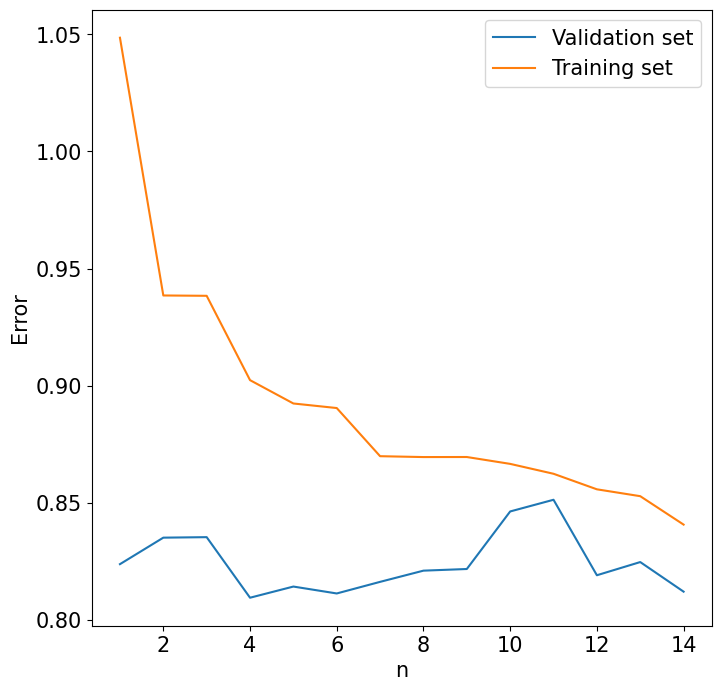

In [28]:
nrange = np.arange(1,15)

etrain, etest= [], []
for n in nrange:
    classifier = astroML.linear_model.PolynomialRegression(n)
    error_train, error_validation = fitanderror(classifier)
    print("Polynomial Regression n=",n, error_train, error_validation)
    etrain.append(error_train)
    etest.append(error_validation)

plt.plot(nrange,etest, label='Validation set')
plt.plot(nrange,etrain, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()

print("Best", nrange[np.argmin(etest)], min(etest))


Basis Function Regression n= 2 0.9390608639663369 0.8372190336290842
Basis Function Regression n= 3 0.9182306875474912 0.8231807935850916
Basis Function Regression n= 4 0.9040293453567941 0.8123014226574881
Basis Function Regression n= 5 0.8972136831556375 0.811951229602886
Basis Function Regression n= 6 0.8968683253324095 0.8053634042331471
Basis Function Regression n= 7 0.8709153680124408 0.8079506193558593
Basis Function Regression n= 8 0.8708055910961254 0.8081563142324666
Basis Function Regression n= 9 0.8707796876159167 0.8084634842381567
Best 6 0.8053634042331471


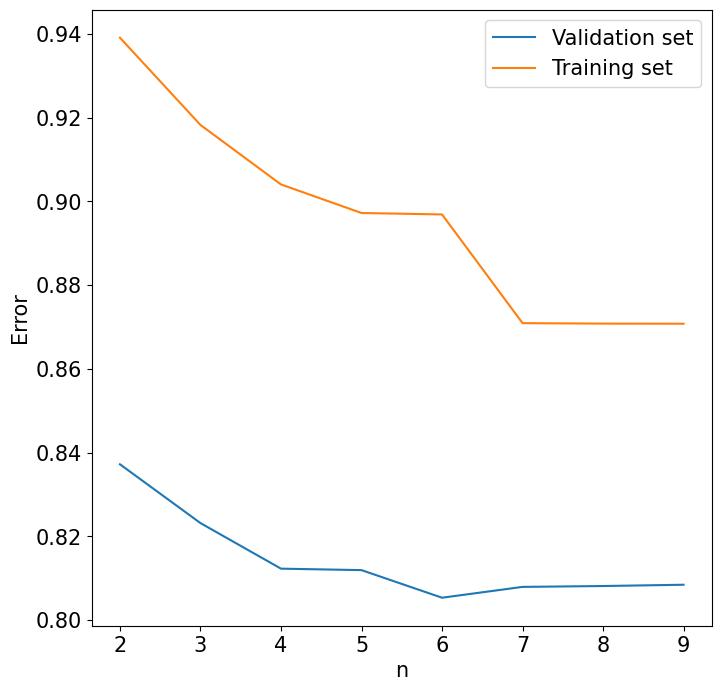

In [29]:
nrange = np.arange(2,10)

etrain, etest= [], []
for n in nrange:
    basis_mu = np.linspace(0,2,n)[:, None]
    basis_sigma = 1.0 * (basis_mu[1] - basis_mu[0])
    classifier = astroML.linear_model.BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    error_train, error_validation = fitanderror(classifier)
    print("Basis Function Regression n=",n, error_train, error_validation)
    etrain.append(error_train)
    etest.append(error_validation)

plt.plot(nrange,etest, label='Validation set')
plt.plot(nrange,etrain, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()

print("Best", nrange[np.argmin(etest)], min(etest));

Kernel Regression bw= 0.01 0.6281270203613113 0.955286631209702
Kernel Regression bw= 0.01191919191919192 0.6580867621108832 0.8942772895966639
Kernel Regression bw= 0.013838383838383839 0.6826959486041289 0.8530876711409691
Kernel Regression bw= 0.01575757575757576 0.7025913900741239 0.8261574596377543
Kernel Regression bw= 0.017676767676767676 0.7184595644432047 0.8082897988099321
Kernel Regression bw= 0.019595959595959597 0.7312131365449729 0.795808196786952
Kernel Regression bw= 0.021515151515151515 0.7417498401397904 0.7862964668909995
Kernel Regression bw= 0.023434343434343433 0.750779323961404 0.7782686103971498
Kernel Regression bw= 0.025353535353535354 0.7587943718193323 0.7708976533937243
Kernel Regression bw= 0.027272727272727275 0.7661263099364197 0.7638226026956613
Kernel Regression bw= 0.029191919191919193 0.7730037502447006 0.7569945148186101
Kernel Regression bw= 0.03111111111111111 0.7795870516925558 0.7505402282935111
Kernel Regression bw= 0.03303030303030303 0.785985

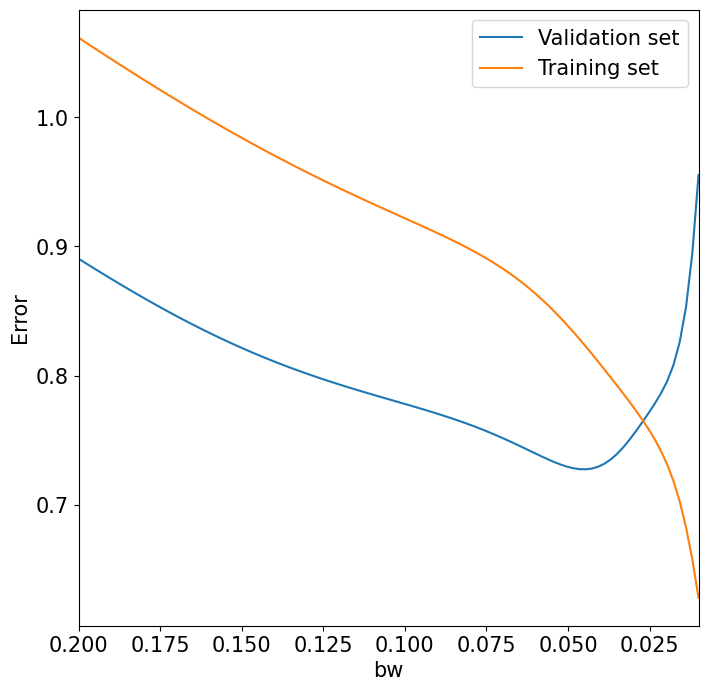

In [30]:
bwrange =  np.linspace(0.01,0.2,100)

etrain, etest= [], []
for bw in bwrange:
    classifier = astroML.linear_model.NadarayaWatson('gaussian', bw)
    error_train, error_validation = fitanderror(classifier)
    print("Kernel Regression bw=",bw, error_train, error_validation)
    etrain.append(error_train)
    etest.append(error_validation)

plt.plot(bwrange,etest, label='Validation set')
plt.plot(bwrange,etrain, label='Training set')

#Flip the x axis. Small bandwidths are conceptually similar to having more degrees of freedom
plt.xlabel('bw')
plt.xlim(bwrange[-1],bwrange[0]) 
plt.ylabel('Error')
plt.legend()

print("Best", bwrange[np.argmin(etest)], min(etest));

#### Best fit model 

Let's take the best polynomial model.

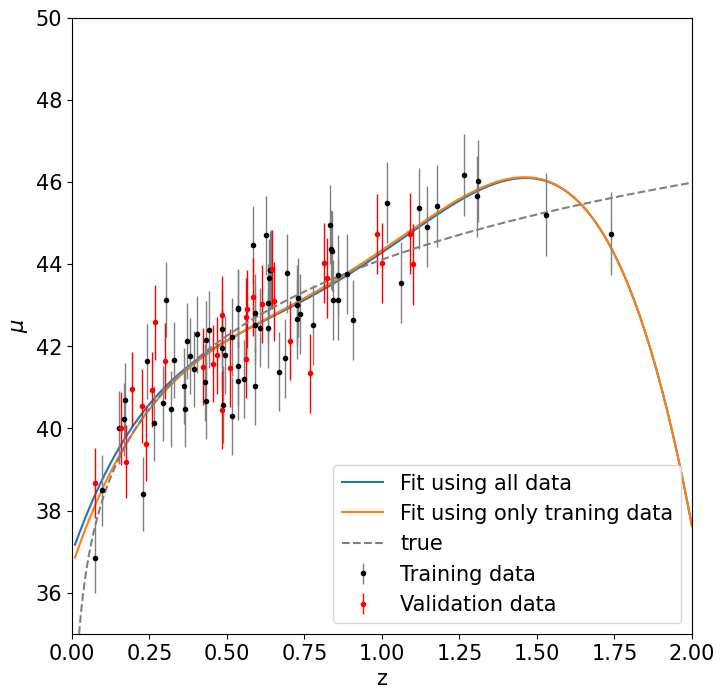

In [31]:
classifier = astroML.linear_model.PolynomialRegression(4)

classifier.fit(z_sample[:,np.newaxis], mu_sample,dmu) # in this case dy is irrelevant because errors are homoscedastic
mu_fit = classifier.predict(z[:,np.newaxis])

mu_fit = classifier.predict(z[:,np.newaxis])

plt.plot(z, mu_fit, label='Fit using all data')


classifier.fit(X_train, y_train,dy_train) # in this case dy is irrelevant because errors are homoscedastic
mu_fit = classifier.predict(z[:,np.newaxis])

plt.plot(z, mu_fit, label='Fit using only traning data')

#plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

plt.errorbar(X_train, y_train, dy_train, fmt='.k', ecolor='gray', lw=1,label='Training data')
plt.errorbar(X_validation, y_validation, dy_validation, fmt='.r', ecolor='red', lw=1, label='Validation data')

plt.plot(z, mu_true, '--', c='gray',label='true')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='lower right');

### Lessons learned

- Look at how the model is able to generalize to unseen data! That's nice and a strong indication we're doing things right here.

- I naively thought the best case would not have had that drop at large values of $z$. But that is extrapolation! It's outside the largest redshift value I have

- Note that I've done this only once! I.e. this is a simple test/train splitting and not a K-fold cross-val. In particular, I very strongly suspect that results might be different if that last data point at $z\gtrsim 0.5$ ends up in the validation set.

- Look at how that last point is influencing the fit! If you're suspicious about individual datapoints, a good check is to try re-fitting when these are excluded. Does the result change significantly?

- If this was for one of my researhc papers, after this plot I would conclude that a test-train splitting is not enough here and I should really dig deeper. 
